# Package Imports

In [1]:
# General.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import numpy as np
import scipy

# Astropy.
import astropy.io.fits as fits
import astropy.units
import astropy.constants
from astropy import units as u 
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle

# Directory/file paths.
import os
from pathlib import Path
from tabulate import tabulate

# Explore calibration files.

In [2]:
# Create array of all calibration files.
dir = Path('mice_bias_flat')
calib_files = []
for f in sorted(dir.rglob("*.fits")):
     calib_files.append(f.name)

In [3]:
# Initalize arrays storing log information.
log_headers = ['File name', 'START TIME (UT)', 'RA (hh:mm:ss)', 'Dec (deg:mm:ss)', 'Object name',
              'Airmass', 'Filter', 'Exposure time (s)']
log = []
dir = 'mice_bias_flat/'

# Populate arrays.
for path in calib_files:
    curr_path = dir + path
    curr_file = fits.open(curr_path)
    header = curr_file[0].header
    
    file_name = path
    ut_time = header['UTCSTART']
    ra = header['RA']
    dec = header['DEC']
    obj_name = header['OBJECT']
    airmass = header['AIRMASS']
    filter = header['FILTER']
    exp_time = header['EXPTIME']

    log.append([file_name, ut_time, ra, dec, obj_name, airmass, filter, exp_time])

    curr_file.close()

# Print table.
print(tabulate(log, headers=log_headers, tablefmt='orgtbl'))

| File name           | START TIME (UT)          | RA (hh:mm:ss)   | Dec (deg:mm:ss)   | Object name   |   Airmass | Filter   |   Exposure time (s) |
|---------------------+--------------------------+-----------------+-------------------+---------------+-----------+----------+---------------------|
| BIAS_1.fits         | 2023-05-12T23:03:26.603Z | 04:07:08.72     | +33:29:02.5       |               |         1 | g'       |                   0 |
| BIAS_10.fits        | 2023-05-12T23:05:56.449Z | 04:07:08.72     | +33:29:02.5       |               |         1 | g'       |                   0 |
| BIAS_11.fits        | 2023-05-12T23:06:12.703Z | 04:07:08.72     | +33:29:02.5       |               |         1 | g'       |                   0 |
| BIAS_2.fits         | 2023-05-12T23:03:44.011Z | 04:07:08.72     | +33:29:02.5       |               |         1 | g'       |                   0 |
| BIAS_3.fits         | 2023-05-12T23:04:00.939Z | 04:07:08.72     | +33:29:02.5       |            

# Create master bias.

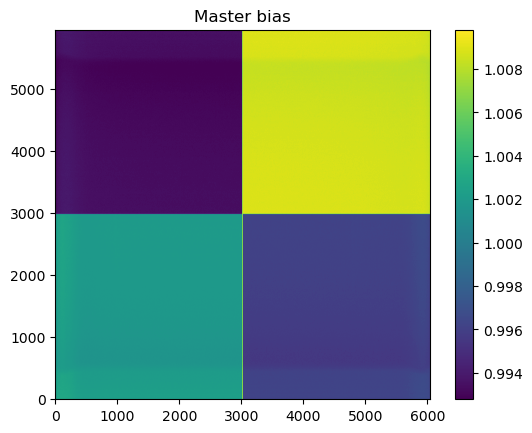

In [4]:
# Median-combine all bias images.
bias_data = []

# Iterate through files.
for path in calib_files:
    curr_path = dir + path
    curr_file = fits.open(curr_path)
    header = curr_file[0].header
    
    if 'BIAS' in path:
        curr_data = curr_file['PRIMARY'].data.astype(float)
        #curr_data = curr_data * (1/exp_time)
        bias_data.append(curr_data)

    curr_file.close()

# Create median datasets.
num_cols = len(bias_data[0])
master_bias = np.zeros_like(np.median(bias_data, axis=0))
np.median(bias_data, axis=0, out=master_bias)

# Crop out 100 from each side.
master_bias = master_bias[100:-100, 100:-100]

# Normalize entire image.
master_bias = master_bias/np.average(master_bias)

# Show figure without outliers.
img = plt.imshow(master_bias, origin='lower', vmin=np.percentile(master_bias, 1), vmax=np.percentile(master_bias, 99))
plt.title('Master bias')
plt.colorbar(img)
plt.show()

# Create master domeflat R.

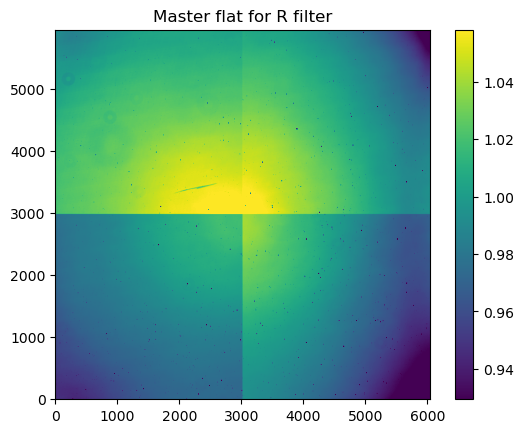

In [5]:
# Median-combine flat R images.
flat_r_data = []

# Iterate through files.
for path in calib_files:
    curr_path = dir + path
    curr_file = fits.open(curr_path)
    header = curr_file[0].header
    
    exp_time = header['EXPTIME']
    
    if 'FLAT_R' in path:
        curr_data = curr_file['PRIMARY'].data.astype(float)
        curr_data = curr_data * (1/exp_time)
        flat_r_data.append(curr_data)

    curr_file.close()

# Create median datasets.
num_cols = len(flat_r_data[0])
master_flat_r = np.zeros_like(np.median(flat_r_data, axis=0))
np.median(flat_r_data, axis=0, out=master_flat_r)

# Crop unilluminated region.
master_flat_r = master_flat_r[100:-100, 100:-100]

# Subtract bias.
master_flat_r = master_flat_r - master_bias

# Normalize entire image.
master_flat_r = master_flat_r/np.average(master_flat_r)

# Show figure without outliers.
img = plt.imshow(master_flat_r, origin='lower', vmin=np.percentile(master_flat_r, 1), vmax=np.percentile(master_flat_r, 99))
plt.title('Master flat for R filter')
plt.colorbar(img)
plt.show()

# Create domeflat I.

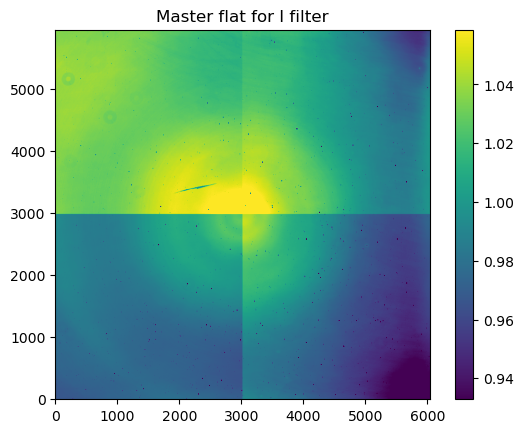

In [6]:
# Median-combine flat I images.
flat_i_data = []

# Iterate through files.
for path in calib_files:
    curr_path = dir + path
    curr_file = fits.open(curr_path)
    header = curr_file[0].header

    exp_time = header['EXPTIME']
    
    if 'FLAT_I' in path:
        curr_data = curr_file['PRIMARY'].data.astype(float)
        curr_data = curr_data * (1/exp_time)
        flat_i_data.append(curr_data)

    curr_file.close()

# Create median datasets.
num_cols = len(flat_i_data[0])
master_flat_i = np.zeros_like(np.median(flat_i_data, axis=0))
np.median(flat_i_data, axis=0, out=master_flat_i)

# Crop unilluminated region.
master_flat_i = master_flat_i[100:-100, 100:-100]

# Subtract bias.
master_flat_i = master_flat_i - master_bias

# Normalize entire image.
master_flat_i = master_flat_i/np.average(master_flat_i)

# Show figure without outliers.
img = plt.imshow(master_flat_i, origin='lower', vmin=np.percentile(master_flat_i, 1), vmax=np.percentile(master_flat_i, 99))
plt.title('Master flat for I filter')
plt.colorbar(img)
plt.show()

# Create domeflat G.

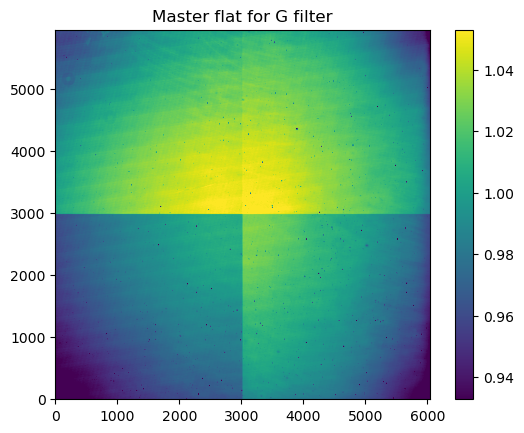

In [7]:
# Median-combine flat G images.
flat_g_data = []

# Iterate through files.
for path in calib_files:
    curr_path = dir + path
    curr_file = fits.open(curr_path)
    header = curr_file[0].header
    
    exp_time = header['EXPTIME']
    
    if 'FLAT_G' in path:
        curr_data = curr_file['PRIMARY'].data.astype(float)
        curr_data = curr_data * (1/exp_time)
        flat_g_data.append(curr_data)

    curr_file.close()

# Create median datasets.
num_cols = len(flat_g_data[0])
master_flat_g = np.zeros_like(np.median(flat_g_data, axis=0))
np.median(flat_g_data, axis=0, out=master_flat_g)

# Crop unilluminated region.
master_flat_g = master_flat_g[100:-100, 100:-100]

# Subtract bias.
master_flat_g = master_flat_g - master_bias

# Normalize entire image.
master_flat_g = master_flat_g/np.average(master_flat_g)

# Show figure without outliers.
img = plt.imshow(master_flat_g, origin='lower', vmin=np.percentile(master_flat_g, 1), vmax=np.percentile(master_flat_g, 99))
plt.title('Master flat for G filter')
plt.colorbar(img)
plt.show()

# Create domeflat H-alpha.

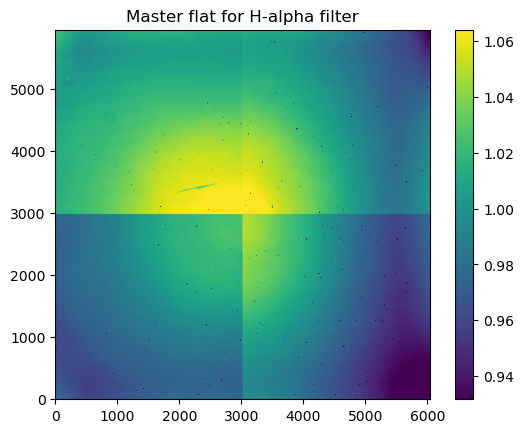

In [8]:
# Median-combine flat Halpha images.
flat_halpha_data = []

# Iterate through files.
for path in calib_files:
    curr_path = dir + path
    curr_file = fits.open(curr_path)
    header = curr_file[0].header
    
    exp_time = header['EXPTIME']
    
    if 'FLAT_HALPHA' in path:
        curr_data = curr_file['PRIMARY'].data.astype(float)
        curr_data = curr_data * (1/exp_time)
        flat_halpha_data.append(curr_data)

    curr_file.close()

# Create median datasets.
num_cols = len(flat_halpha_data[0])
master_flat_halpha = np.zeros_like(np.median(flat_halpha_data, axis=0))
np.median(flat_halpha_data, axis=0, out=master_flat_halpha)

# Crop unilluminated region.
master_flat_halpha = master_flat_halpha[100:-100, 100:-100]

# Subtract bias.
master_flat_halpha = master_flat_halpha - master_bias

# Normalize entire image.
master_flat_halpha = master_flat_halpha/np.average(master_flat_halpha)

# Show figure without outliers.
img = plt.imshow(master_flat_halpha, origin='lower', vmin=np.percentile(master_flat_halpha, 1), vmax=np.percentile(master_flat_halpha, 99))
plt.title('Master flat for H-alpha filter')
plt.colorbar(img)
plt.show()

# Explore image data.

In [9]:
# Create array of all image files.
img_dir = Path('mice_imgs')
img_files = []
for f in sorted(img_dir.rglob("*.fits")):
     img_files.append(f.name)

In [10]:
# Initalize arrays storing log information.
log_headers = ['File name', 'START TIME (UT)', 'RA (hh:mm:ss)', 'Dec (deg:mm:ss)', 'Object name',
              'Airmass', 'Filter', 'Exposure time (s)']
log = []
img_dir = 'mice_imgs/'

# Populate arrays.
for path in img_files:
    curr_path = img_dir + path
    curr_file = fits.open(curr_path)
    header = curr_file[0].header
    
    file_name = path
    ut_time = header['UTCSTART']
    ra = header['RA']
    dec = header['DEC']
    obj_name = header['OBJECT']
    airmass = header['AIRMASS']
    filter = header['FILTER']
    exp_time = header['EXPTIME']

    log.append([file_name, ut_time, ra, dec, obj_name, airmass, filter, exp_time])

    curr_file.close()

# Print table.
print(tabulate(log, headers=log_headers, tablefmt='orgtbl'))

| File name             | START TIME (UT)          | RA (hh:mm:ss)   | Dec (deg:mm:ss)   | Object name   |   Airmass | Filter   |   Exposure time (s) |
|-----------------------+--------------------------+-----------------+-------------------+---------------+-----------+----------+---------------------|
| NGC4676_G_1.fits      | 2023-05-13T05:40:14.530Z | 04:07:08.72     | +33:29:02.5       | NGC4676       |         1 | g'       |                 480 |
| NGC4676_G_2.fits      | 2023-05-13T05:48:56.001Z | 04:07:08.72     | +33:29:02.5       | NGC4676       |         1 | g'       |                 480 |
| NGC4676_G_3.fits      | 2023-05-13T05:57:37.477Z | 04:07:08.72     | +33:29:02.5       | NGC4676       |         1 | g'       |                 480 |
| NGC4676_HALPHA_1.fits | 2023-05-13T07:04:39.687Z | 04:07:08.72     | +33:29:02.5       | NGC4676       |         1 | H-alpha  |                 720 |
| NGC4676_HALPHA_2.fits | 2023-05-13T07:17:38.527Z | 04:07:08.72     | +33:29:02.5      

# Create R image.

In [11]:
def clean_img(img_files, filt):
    img_data = []

    for path in img_files:
        curr_path = img_dir + path
        curr_file = fits.open(curr_path)
        header = curr_file[0].header
        
        obj_name = header['OBJECT']
        exp_time = header['EXPTIME']
        filter = header['FILTER']
        
        if filt in filter:
            curr_data = curr_file['PRIMARY'].data.astype(float)
            img_data.append(curr_data)

        curr_file.close()
    
    # Create median datasets.
    num_cols = len(img_data[0])
    master_img = np.zeros_like(np.median(img_data, axis=0))
    np.median(img_data, axis=0, out=master_img)

    # Crop unilluminated region.
    master_img = master_img[100:-100, 100:-100]

    # Subtract bias.
    master_img = master_img - master_bias

    if filt == 'r':
        master_flat = master_flat_r 
    if filt == 'g':
        master_flat = master_flat_g
    if filt == 'i':
        master_flat = master_flat_i
    if filt == 'alpha':
        master_flat = master_flat_halpha

    # Flatfield data.
    master_img = master_img / master_flat

    return master_img

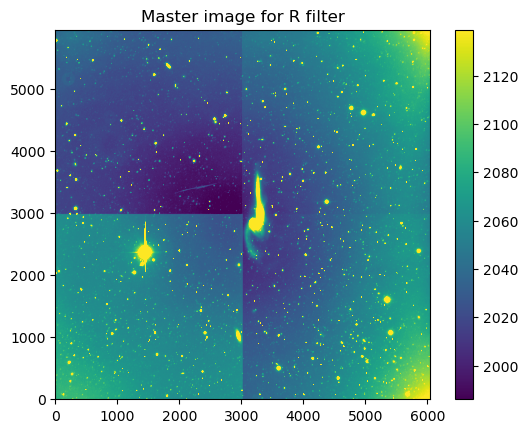

In [12]:
master_img_r = clean_img(img_files, 'r')

# Show figure without outliers.
img = plt.imshow(master_img_r, origin='lower', vmin=np.percentile(master_img_r, 1), vmax=np.percentile(master_img_r, 99))
plt.title('Master image for R filter')
plt.colorbar(img)
plt.show()

# Create I image.

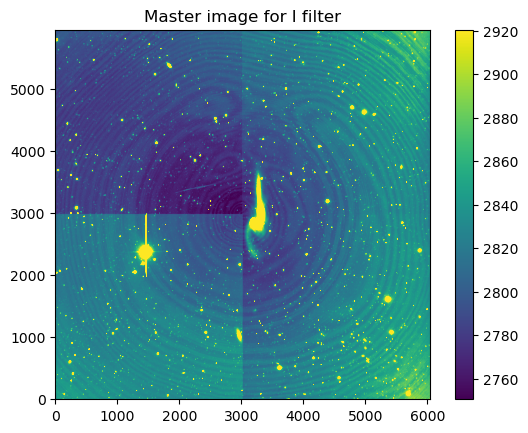

In [13]:
master_img_i = clean_img(img_files, 'i')

# Show figure without outliers.
img = plt.imshow(master_img_i, origin='lower', vmin=np.percentile(master_img_i, 1), vmax=np.percentile(master_img_i, 99))
plt.title('Master image for I filter')
plt.colorbar(img)
plt.show()

# Create G image.

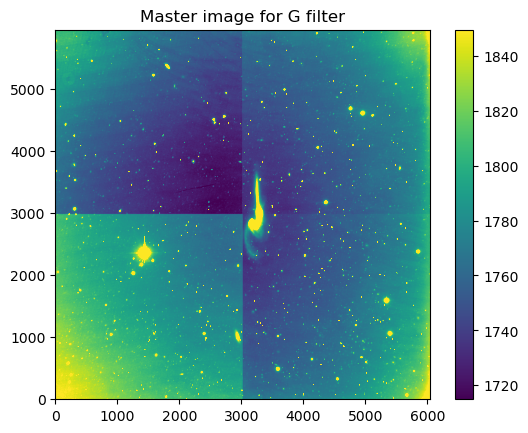

In [14]:
master_img_g = clean_img(img_files, 'g')

# Show figure without outliers.
img = plt.imshow(master_img_g, origin='lower', vmin=np.percentile(master_img_g, 1), vmax=np.percentile(master_img_g, 99))
plt.title('Master image for G filter')
plt.colorbar(img)
plt.show()

# Create H-alpha image.

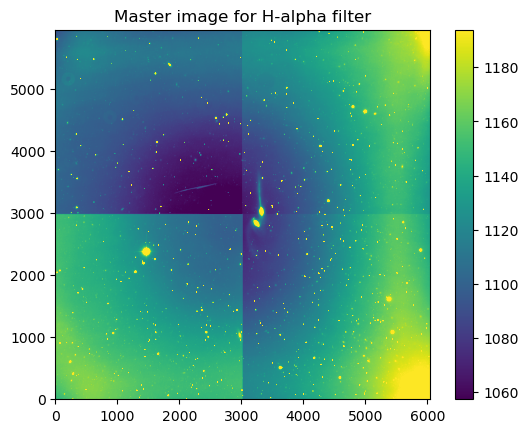

In [15]:
master_img_halpha = clean_img(img_files, 'alpha')

# Show figure without outliers.
img = plt.imshow(master_img_halpha, origin='lower', vmin=np.percentile(master_img_halpha, 1), vmax=np.percentile(master_img_halpha, 99))
plt.title('Master image for H-alpha filter')
plt.colorbar(img)
plt.show()

# Combine the filters.

In [16]:
import math

def sqrt(inputArray, scale_min=None, scale_max=None):
	"""Performs sqrt scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array

	"""
	imageData=np.array(inputArray, copy=True)

	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()

	imageData = imageData.clip(min=scale_min, max=scale_max)
	imageData = imageData - scale_min
	indices = np.where(imageData < 0)
	imageData[indices] = 0.0
	imageData = np.sqrt(imageData)
	imageData = imageData / math.sqrt(scale_max - scale_min)

	return imageData

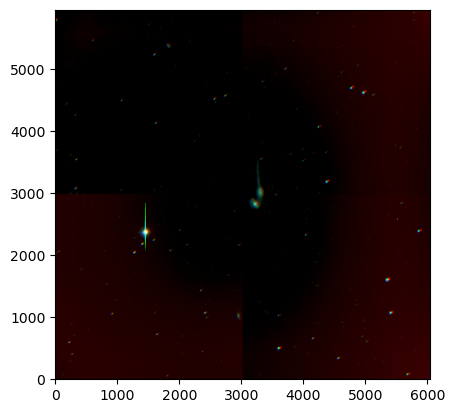

In [109]:
from astropy.visualization import make_lupton_rgb

r = ((master_img_r - master_img_r.min()) / (master_img_r.max() - master_img_r.min())) * 255
g = ((master_img_g - master_img_g.min()) / (master_img_g.max() - master_img_g.min())) * 255
i = ((master_img_i - master_img_i.min()) / (master_img_i.max() - master_img_i.min())) * 255
halpha = ((master_img_halpha - master_img_halpha.min()) / (master_img_halpha.max() - master_img_halpha.min())) * 255

#rgb_default = make_lupton_rgb(i, r, g, Q=0.1, stretch=1, filename="ngc4676-default.jpeg")



img = np.zeros((r.shape[0], r.shape[1], 3), dtype=float)
min = 0.35
max = 5
img[:,:,0] = sqrt(halpha*0.5, scale_min=min, scale_max=max)
img[:,:,1] = sqrt(r*0.75, scale_min=min, scale_max=max)
img[:,:,2] = sqrt(g*0.15, scale_min=min, scale_max=max)

plt.imshow(img, origin='lower', vmin=np.percentile(img, 1), vmax=np.percentile(img, 99))
#plt.savefig("mice.png", dpi=1200)
plt.show()